In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano
import theano.tensor as tt


random_state = np.random.RandomState(42)

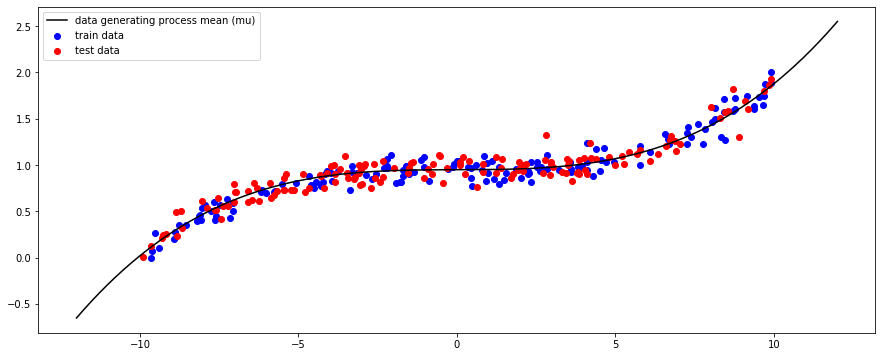

In [2]:
# make data

def fake_model(x):
    #return 200.0 * x
    return x**3 + x

num_samples = 150
scale_factor = 100

x_train = np.random.uniform(-10, 10, num_samples)
x_train = x_train.reshape(-1, 1)
y_train = fake_model(x_train) + random_state.normal(0, 100, num_samples).reshape(-1, 1) 

x_test = np.random.uniform(-10, 10, num_samples)
x_test = x_test.reshape(-1, 1)
y_test = fake_model(x_test) + random_state.normal(0, 100, num_samples).reshape(-1, 1)

feature_space = np.linspace(-12, 12, 1000).reshape(-1, 1)
y_true = fake_model(feature_space)

# scale data (best practice for good results)

y_train_max = y_train.max()
y_train_min = y_train.min()

def scale(y):
    return 2.0* (y - y_train_min) / (y_train_max - y_train_min)

y_train = scale(y_train)
y_test = scale(y_test)
y_true = scale(y_true)

x_train = x_train.astype("float32")
y_train = y_train.astype("float32")
x_test = x_test.astype("float32")
y_test = y_test.astype("float32")
feature_space = feature_space.astype("float32")
y_true = y_true.astype("float32")

# plot data

train_color = "b"
test_color = "r"

plt.figure(figsize=(15, 6))
plt.plot(feature_space[:, 0], y_true, c="k", label="data generating process mean (mu)")
plt.scatter(x_train[:, 0], y_train[:, 0], c=train_color, label="train data")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.legend()
plt.show()

In [3]:
X = x_train
Y = y_train

ann_input = theano.shared(X)
ann_output = theano.shared(Y)

n_hidden = 3
dtype = theano.config.floatX
    
# Initialize random weights between each layer
# init_1 = np.random.randn(X.shape[1], n_hidden).astype(dtype)
# init_b_1 = np.random.randn(n_hidden).astype(dtype)

# init_2 = np.random.randn(n_hidden, Y.shape[1]).astype(dtype)
# init_b_2 = np.random.randn(Y.shape[1]).astype(dtype)

# init_out = np.random.randn(Y.shape[1]).astype(dtype)
# init_b_out = np.random.randn(Y.shape[1]).astype(dtype)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], n_hidden))#, testval=init_1)
    weights_b_1 = pm.Normal('w_b_1', 0, sd=1, shape=(n_hidden))#, testval=init_b_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden))#, testval=init_2)
    weights_b_2 = pm.Normal('w_b_2', 0, sd=1, shape=(n_hidden))#, testval=init_b_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden, Y.shape[1]))#, testval=init_out)
    weights_b_out = pm.Normal('w_b_out', 0, sd=1, shape=(Y.shape[1]))#, testval=init_b_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + weights_b_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + weights_b_2)
    act_out = pm.math.dot(act_2, weights_2_out) + weights_b_out
        
    variance = pm.HalfNormal('uncertainty', sigma=1.0)    
    out = pm.Normal('out', mu=act_out, sigma=variance, observed=ann_output)

In [5]:
with neural_network:
    step = pm.NUTS()
    trace = pm.sample(1000, tune=100, cores=1, chains=1, step=step)
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     pm.fit(n=20000, method=inference)
#     s.set_value(0)
#     approx = pm.fit(n=30000)
#     trace = approx.sample(draws=5000)

Sequential sampling (1 chains in 1 job)
NUTS: [uncertainty, w_b_out, w_2_out, w_b_2, w_1_2, w_b_1, w_in_1]
Sampling chain 0, 68 divergences: 100%|██████████| 1100/1100 [02:38<00:00,  6.94it/s]
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
new_x = np.linspace(-15, 15, 100)[:, None].astype("float32")
ann_input.set_value(new_x)

ppc = pm.sample_ppc(trace, model=neural_network, samples=200)

/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
100%|██████████| 200/200 [00:02<00:00, 69.29it/s]


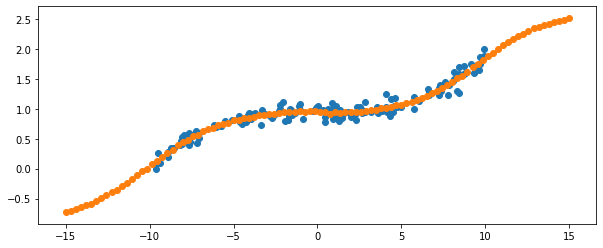

In [20]:
y_pred = ppc["out"].mean(axis=0)[:, None]

plt.figure(figsize=(10, 4))
plt.scatter(x_train[:,0], y_train[:, 0])
plt.scatter(new_x[:, 0], y_pred[:, 0])
plt.show()